In [3]:
from matplotlib import pyplot as plt
import random
from copy import deepcopy
import networkx as nx
import callable
import time
import os
import numpy as np
from tabulate import tabulate


In [81]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
            
    return maxDegree

In [5]:
def normEdge(u, v):
    return (u, v) if u < v else (v, u)

In [6]:
def calcConflicts(edges, edgesIndex, solution, neighbourhood):
    num  = 0
    
    for i in range(len(edges)):
        edge = edges[i]
        myNeighbours = neighbourhood[edge]

        for nei in myNeighbours:
            idx = edgesIndex[nei]
            if solution[idx] == solution[i]:
                num += 1
        
    return (num // 2)


In [7]:
def recalcConflicts(edges, edgesIndex, oldConf, solution, neighbourhood, oldColour, newColour, i):
    num = 0

    edge = edges[i]
    myNeighbours = neighbourhood[edge]

    for nei in myNeighbours:
        idx = edgesIndex[nei]
        if solution[idx] == oldColour:
            num -= 1
        if solution[idx] == newColour:
            num += 1
    
    return oldConf + num


In [8]:
def getNeighbours(graph):
    neighbourhood = {normEdge(u, v): [] for _, (u, v) in enumerate(graph.edges())} 


    for edge in graph.edges():
        u, v = edge
        uNei = list(graph.neighbors(u))
        vNei = list(graph.neighbors(v))
        uNei.remove(v)
        vNei.remove(u)
        mapa = {}

        for i in    uNei:
            nei = normEdge(u, i)
            neighbourhood[edge].append(nei)
            mapa[nei] = True

        for i in vNei:
            nei = normEdge(v, i)
            if nei not in mapa:
              neighbourhood[edge].append(nei)
    # print(neighbourhood)

    return neighbourhood

In [9]:
def shakingRand(solution, maxDegree, _edges, _neighbourhood, _edgesIndex, k):

    
    newSolution = deepcopy(solution)
    chosen = random.sample(range(len(solution)),k)
    
    for i in chosen:
        newSolution[i] = random.randrange(1, maxDegree+1)
    return newSolution

In [ ]:
def shakingSwap(solution, _maxDegree, _edges, _neighbourhood, _edgesIndex, k):
    newSolution = deepcopy(solution)

    for _ in range(k):
        newSolution = np.random.permutation(newSolution)

    
    return newSolution.tolist()



In [ ]:
def shakingNeigh(solution, maxDegree, edges, neighbourhood, edgesIndex, _k):
    newSolution = deepcopy(solution)
    i = random.randrange(len(newSolution))
    edge = edges[i]
    # print(edge)

    myNeis = neighbourhood[edge]
    for nei in myNeis:
        idx = edgesIndex[nei]
        newSolution[idx] = random.randrange(1,maxDegree+1)
    return newSolution


In [12]:
def lsFirst(edges, edgesIndex, solution, fitness, maxDegree, neighbourhood):
    newSolution = deepcopy(solution)
    improved = True

    while improved:
        improved = False
        indices = list(range(len(solution)))
        random.shuffle(indices)

        for i in indices:
            oldColour = newSolution[i]
            for colour in range(1,maxDegree+1):
                if colour == oldColour:
                    continue
                newSolution[i] = colour
                # newSolution[i] = random.randrange(1, maxDegree+1)
                # newFitness = calcConflicts(graph, newSolution, neighbourhood)
                newFitness = recalcConflicts(edges, edgesIndex, fitness, newSolution, neighbourhood, oldColour, colour, i)
                if newFitness < fitness:
                    fitness = newFitness
                    improved = True
                    break
                else:
                    newSolution[i] = oldColour
    return newSolution, fitness


In [13]:
def lsBest(edges, edgesIndex, solution, fitness, maxDegree, neighbourhood):
    newSolution = deepcopy(solution)
    improved = True

    while improved:
        improved = False
        bestFitness = fitness
        bestIdx = -1
        bestColour = -1

        for i in range(len(solution)):
            oldColour = newSolution[i]
            for colour in range(1,maxDegree+1):
                if colour == oldColour:
                    continue
                newSolution[i] = colour
                # newFitness = calcConflicts(graph, newSolution, neighbourhood)
                newFitness = recalcConflicts(edges, edgesIndex, fitness, newSolution, neighbourhood, oldColour, colour, i)
                if newFitness < bestFitness:
                    bestFitness = newFitness
                    bestIdx = i
                    bestColour = colour
                newSolution[i] = oldColour
        
        if bestIdx != -1:
            newSolution[bestIdx] = bestColour
            fitness = bestFitness
            improved = True

    return newSolution, fitness


In [54]:
def lsTabu(edges, edgesIndex, solution, fitness, maxDegree, neighbourhood):

    bestSolution = deepcopy(solution)
    currentSolution = deepcopy(solution)
    bestFitness = fitness
    currentFitness = fitness

    tabuStep = 7
    tabuList = {}

    iteration = 0

    while iteration < 500 and bestFitness > 0:
        
        iteration += 1
        bestMoveFitness = float('inf')
        bestMove = None

        for i in range(len(solution)):
            oldColour = currentSolution[i]
            for colour in range(1,  maxDegree + 1):
                if oldColour == colour:
                    continue
                currentSolution[i] = colour
                newFitness = recalcConflicts(edges, edgesIndex, currentFitness, currentSolution, neighbourhood, oldColour, colour, i)
                currentSolution[i] = oldColour

                move = (i, oldColour)
                isTabu = tabuList.get(move, 0) > iteration

                if isTabu and newFitness >= bestFitness:
                    continue
                if newFitness < bestMoveFitness:
                    bestMoveFitness = newFitness
                    bestMove = (i, colour, oldColour)

        if bestMove is None:
            break

        i, newColour, oldColour = bestMove
        currentSolution[i] = newColour
        currentFitness = bestMoveFitness

        tabuList[(i, oldColour)] = iteration + tabuStep

        if currentFitness < bestFitness:
            bestFitness = currentFitness
            bestSolution = deepcopy(currentSolution)
    
    return bestSolution, bestFitness

In [14]:
def initialize(graph, max_degree):
    return [random.randrange(1,max_degree + 1) for _ in range(len(graph.edges))]

In [15]:
def vns(graph, maxDegree, maxIters, neighRange, probVal, localSearch: callable, shaking: callable):
    solution = initialize(graph,maxDegree)
    neighbourhood = getNeighbours(graph)
    edges = list(graph.edges())
    edgesIndex = {normEdge(u, v) : i for i, (u, v) in enumerate(edges)}

    fitness = calcConflicts(edges, edgesIndex, solution, neighbourhood)
    k = 1

    for it in range(maxIters):
        # for k in range(1,neighRange+1):
        while k <= neighRange:
            
            newSolution = shaking(solution, maxDegree, edges,neighbourhood, edgesIndex, k)
            # newSolution = shakingSwap(solution, k, maxDegree)
            # newSolution = shakingNeigh(solution, maxDegree, edges,neighbourhood, edgesIndex)
            newFitness = calcConflicts(edges, edgesIndex, newSolution, neighbourhood)
            newSolution, newFitness = localSearch(edges, edgesIndex, newSolution, newFitness, maxDegree, neighbourhood)

            if newFitness < fitness or (newFitness == fitness and random.random() < probVal):
                fitness = newFitness
                solution = deepcopy(newSolution)
                k = 1
            else: 
                # k = (k % neighRange) + 1
                k += 1
    return solution, fitness



In [16]:
def draw(graph, colouring):
    nx.draw(graph, edge_color=colouring,with_labels=True)
    plt.show()

In [108]:
def solve(graph, iters, neighRange, prob, localSearch:callable, shaking: callable):

    maxDegree = maxNumOfColours(graph)
    startTime = time.time()

    solution, fitness = vns(graph, maxDegree, iters, neighRange, prob, localSearch, shaking)
    
    endTime = time.time()
    tim = endTime - startTime
    numColours = list(set(solution))

    return [localSearch.__name__, shaking.__name__, fitness, len(numColours), tim, solution, maxDegree]


In [18]:
def readGraph(filepath):

    graph = nx.Graph()
    numNodes: int
    edges = []

    with open(filepath) as f:
        lines = f.readlines()
        numNodes = int(lines[0].split()[2])
        edges = [tuple(map(int,line.split()[1:])) for line in lines[1:]]

    graph.add_nodes_from(range(1, numNodes + 1))
    graph.add_edges_from(edges)
    return graph


In [43]:
def getBest(result):
    return min(range(len(result)), key= lambda i : (result[i][2], result[i][-1]))    

In [51]:
def writeOutput(maxDegree,filename, table, foundMin: bool):
    with open(f'resultsVNS/{filename}', 'w') as file:
        file.write(f"Graph can be coloured with {maxDegree} or {maxDegree + 1} colours. Class 1 or class 2 respectively.\n")
        file.write(table + "\n")
        message = ""
        if(foundMin):
            message = "Graph is class 1, meaning chromatix index is equal to the graph's degree."
        else:
            message = "No conflict-free colouring is found, therefore graph is classified as class 2."
        file.write(message)
        


In [82]:
def testGraphs(dir): #params
    files = os.listdir(dir)

    headers = ["localSearch", "shaking","num of conf/fitness", "num of colours", "time"]
    inserts = []
    colorsRes = []
    localSearches = [lsBest, lsFirst, lsTabu]
    shakings = [shakingRand, shakingSwap ,shakingNeigh]

    for file in files:
        filepath = os.path.join(dir,file)
        print(f"{file} testing...")

        graph = readGraph(filepath)
        foundMin = False
        
        for ls in localSearches:
            for shake in shakings:
                
                result = solve(graph, 100, 4, 0.5, ls,shake)

                if result[2] == 0:
                    foundMin = True
                
                inserts.append(result[:-2])
                colorsRes.append(result[-2])

        table = tabulate(inserts, headers=headers, tablefmt="fancy_grid",showindex=True)
        i = getBest(inserts)
        print(f"Best:  {inserts[i][0]}, {inserts[i][1]}, time: {inserts[i][4]}. No. of conflicts {inserts[i][2]}")
        draw(graph, colorsRes[i])
        writeOutput(result[-1], file, table, foundMin)
        
        inserts.clear()
        colorsRes.clear()



In [ ]:
def testOneGraph(filepath):
    graph = readGraph(filepath)
    headers = ["localSearch", "shaking","num of conf/fitness", "num of colours", "time"]
    inserts = []
    colorsRes = []
    localSearches = [lsBest, lsFirst, lsTabu]
    shakings = [shakingRand, shakingSwap, shakingNeigh]
    foundMin = False

    for ls in localSearches:
        for shake in shakings:
            result = solve(graph, 100, 4, 0.5, ls,shake)
            if result[2] == 0:
                foundMin = True
            inserts.append(result[:-2])
            colorsRes.append(result[-2])

    table = tabulate(inserts, headers=headers, tablefmt="fancy_grid",showindex=True)
    i = getBest(inserts)
    print(f"Best:  {inserts[i][0]}, {inserts[i][1]}, time: {inserts[i][4]}. No. of conflicts {inserts[i][2]}")
    draw(graph, colorsRes[i])

    file = str(filepath).split('/')[-1]
    writeOutput(result[-1], file, table, foundMin)
    

graph5.txt testing...
Best:  lsBest, shakingSwap, time: 0.0001399517059326172. No. of conflicts 0


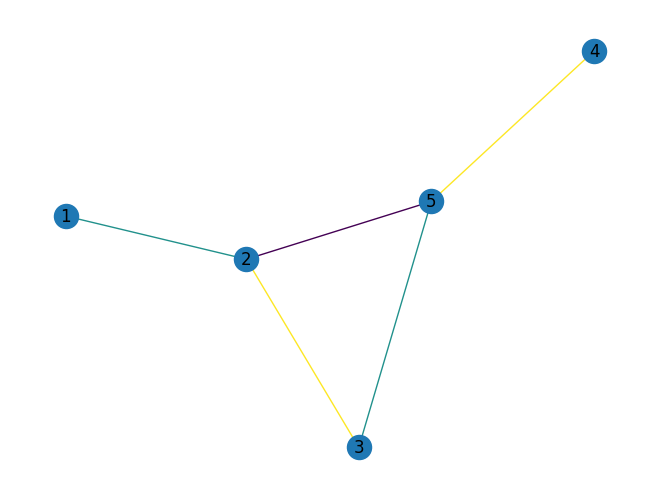

graph6e.txt testing...
Best:  lsFirst, shakingSwap, time: 0.00043582916259765625. No. of conflicts 0


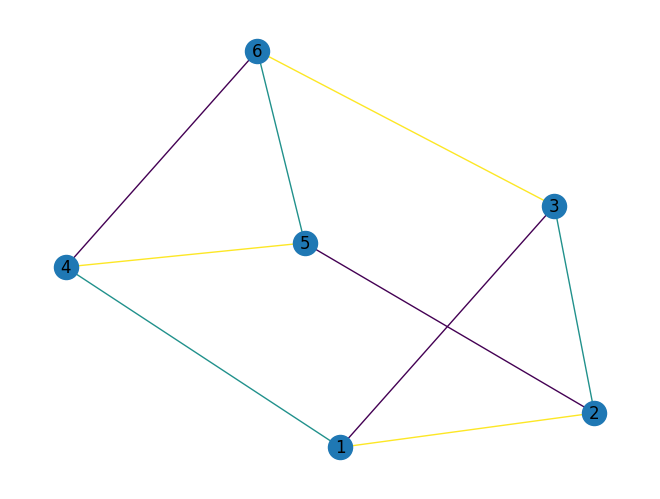

graph10.txt testing...
Best:  lsFirst, shakingNeigh, time: 0.0004837512969970703. No. of conflicts 1


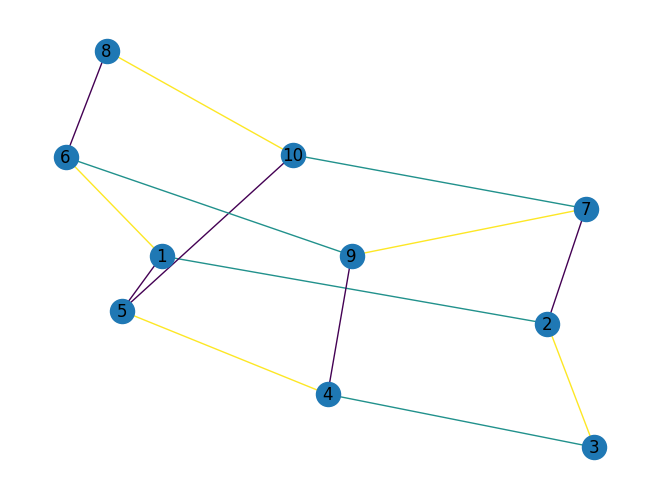

In [83]:
testGraphs("tests")

Best:  lsFirst, shakingNeigh, time: 0.04877614974975586. No. of conflicts 0


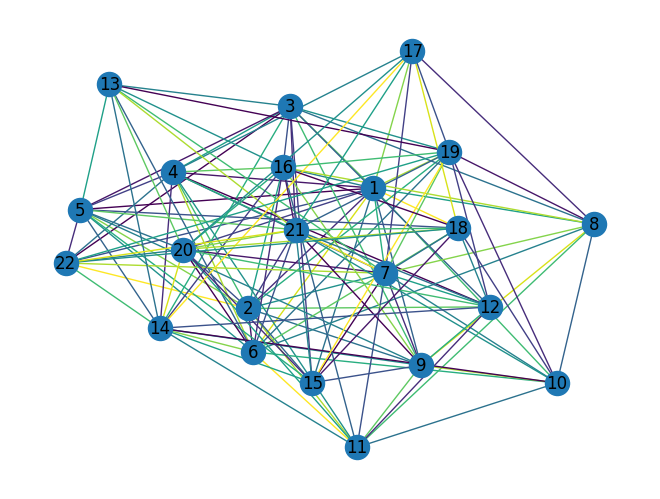

In [ ]:
testOneGraph("bigTests/big22.txt")

Best:  lsFirst, shakingSwap, time: 0.5554633140563965. No. of conflicts 0


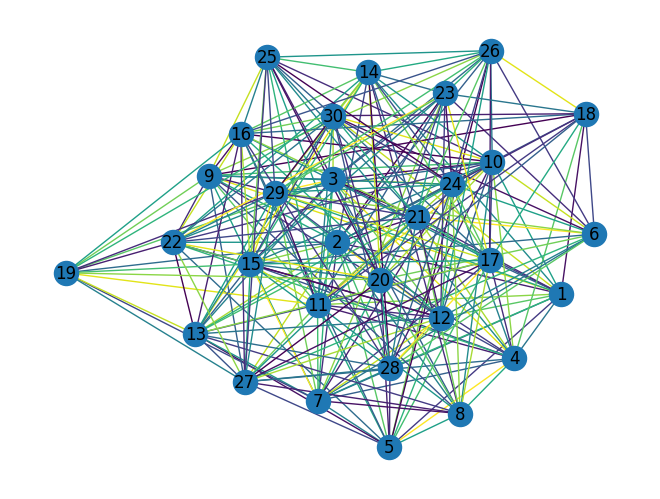

In [ ]:
testOneGraph("bigTests/big25.txt")

Best:  lsFirst, shakingRand, time: 0.09735321998596191. No. of conflicts 0


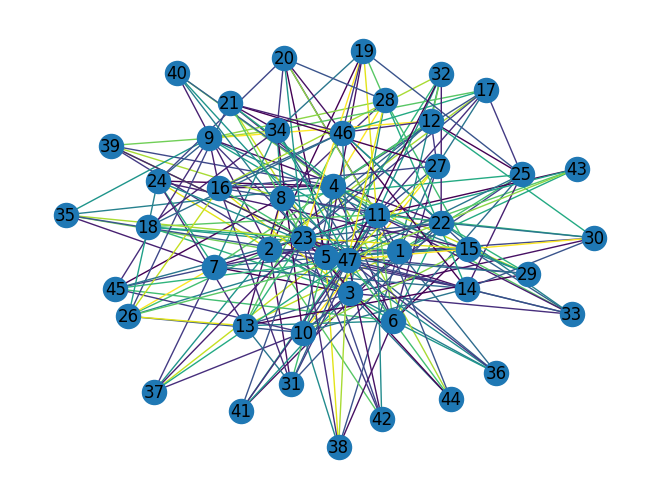

In [ ]:
testOneGraph("bigTests/big47.6.txt")

Best:  lsFirst, shakingSwap, time: 1.8394150733947754. No. of conflicts 0


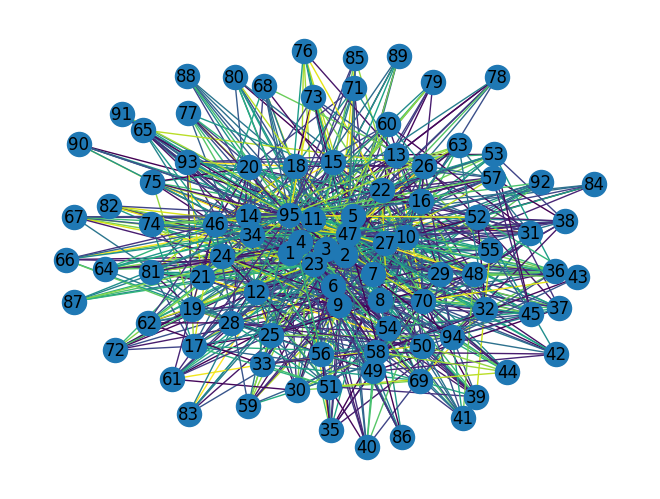

In [ ]:
testOneGraph("bigTests/big75.txt")

Experimental graphs

In [104]:
def testRandomGraph(graph,graphName):
    headers = ["localSearch", "shaking","num of conf/fitness", "num of colours", "time"]
    inserts = []
    colorsRes = []
    localSearches = [lsBest, lsFirst]
    shakings = [shakingRand, shakingSwap, shakingNeigh]
    foundMin = False

    for ls in localSearches:
        for shake in shakings:
            result = solve(graph, 100, 4, 0.5, ls,shake)
            if result[2] == 0:
                foundMin = True
            inserts.append(result[:-2])
            colorsRes.append(result[-2])

    table = tabulate(inserts, headers=headers, tablefmt="fancy_grid",showindex=True)
    i = getBest(inserts)
    print(f"Best:  {inserts[i][0]}, {inserts[i][1]}, time: {inserts[i][4]}. No. of conflicts {inserts[i][2]}")
    draw(graph, colorsRes[i])

    writeOutput(result[-1], graphName, table, foundMin)

In [110]:
def snarkGraph():
    graph = nx.petersen_graph()
    testRandomGraph(graph, "snark.txt")

In [107]:
def randomGraphs(n, p):
    graph = nx.gnp_random_graph(n, p)
    testRandomGraph(graph, f'graph{n}_{p}.txt')

Best:  lsFirst, shakingNeigh, time: 0.0002796649932861328. No. of conflicts 2


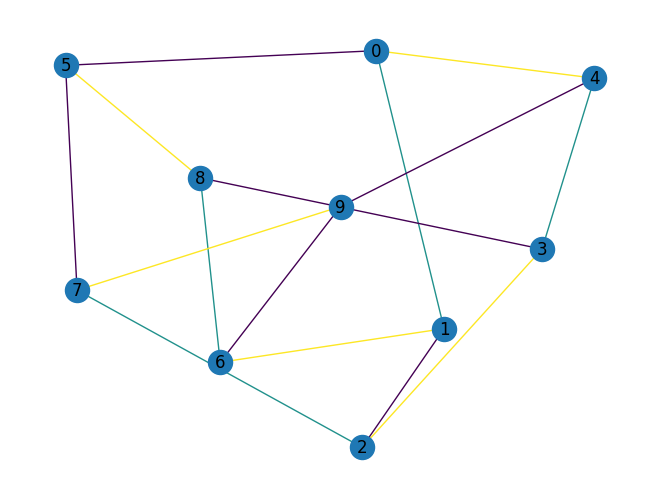

In [111]:
snarkGraph()

Best:  lsBest, shakingNeigh, time: 9.791367530822754. No. of conflicts 0


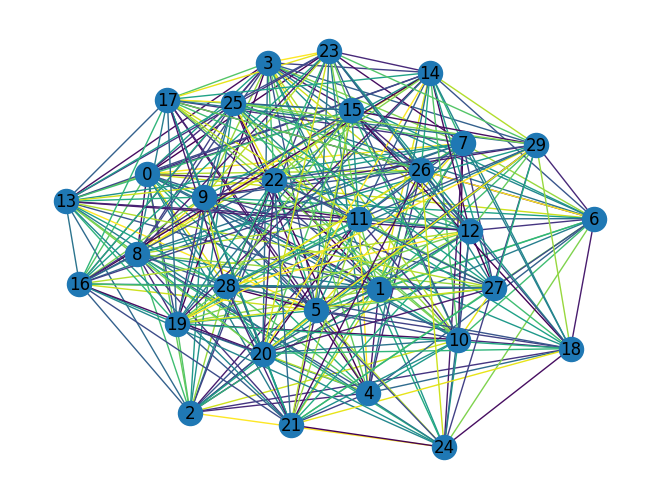

In [109]:
randomGraphs(30,0.8)